<a href="https://colab.research.google.com/github/paluuuk/Customer-segmentation/blob/main/Aerial_Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up colab gpu runtime environment

In [63]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-oktot3rl
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-oktot3rl
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

https://www.cs.toronto.edu/~vmnih/data/


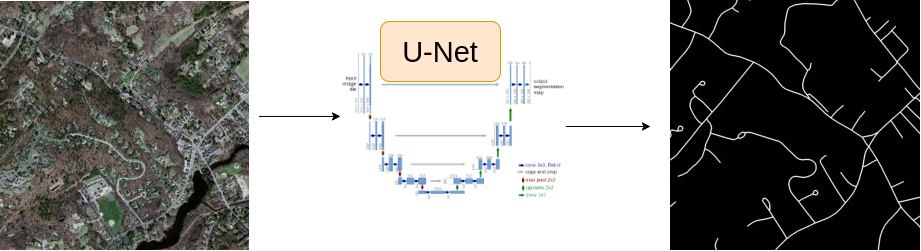

# Download Subset Dataset

In [4]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 18.30 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Imports

In [5]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [6]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Setup Configurations

In [7]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE =512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [9]:
idx = 2

row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

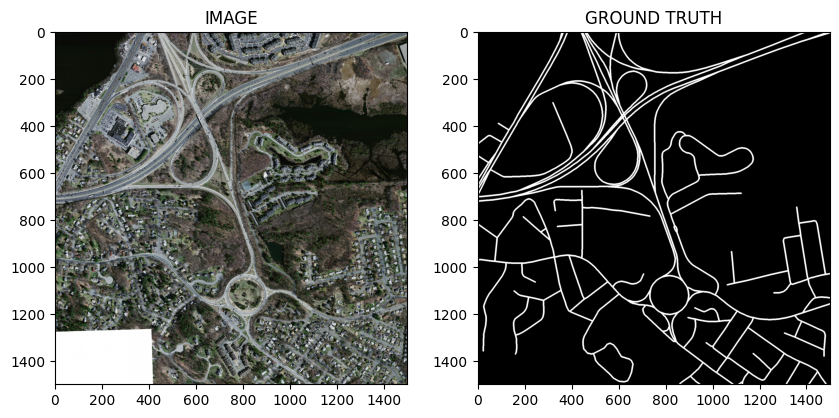

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [11]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state= 42)

# Augmentation Functions

In [12]:
import albumentations as A

In [13]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Create Custom Dataset

In [14]:
from torch.utils.data import Dataset

In [15]:
class segmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #(height, width, channel)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(height , width)
    mask = np.expand_dims(mask, axis = -1) #(height, width, channel) channel will be 1 since it is grayscale

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image'] #(height, width, channel)
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32) #(channel, height, width)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32) #(channel, height, width)

    image = torch.Tensor(image) / 255.0
    mask =  torch.round(torch.Tensor(mask) /  255.0)

    return image, mask

In [16]:
trainset = segmentationDataset(train_df, get_train_augs())
validset = segmentationDataset(valid_df, get_valid_augs())

In [17]:
print(f'Size of trainset: {len(trainset)}')
print(f'Size of validset: {len(validset)}')

Size of trainset: 159
Size of validset: 40


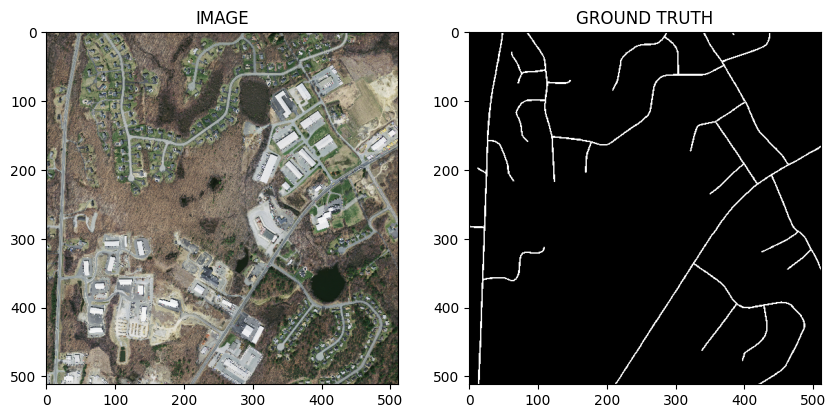

In [18]:
idx = 35

image, mask = validset[idx]
helper.show_image(image, mask)

# Load dataset into batches

In [19]:
from torch.utils.data import DataLoader

In [20]:
trainloader =  DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader =  DataLoader(validset, batch_size = BATCH_SIZE, shuffle = True)

In [21]:
print(f'Total number of batches in trainloader : {len(trainloader)}')
print(f'Total number of batches in validloader : {len(validloader)}')

Total number of batches in trainloader : 20
Total number of batches in validloader : 5


In [22]:
for images, masks in trainloader:
  print(f'One batch image shape : {images.shape}')
  print(f'One batch mask shape : {masks.shape}')
  break;

  #[batch, channel, height, width]

One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([8, 1, 512, 512])


# Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [23]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [31]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None

    )

  def forward(self, images, masks = None):

    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [32]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# Create Train and Validation Function

In [33]:
def train_fn(dataloader, model, optimizer):

  model.train() # turn ON dropout, batchnorm, etc..

  total_loss = 0.0

  for images, masks in tqdm(dataloader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [34]:
def eval_fn(dataloader, model):

  model.eval() # turn OFF dropout, batchnorm, etc..

  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(dataloader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)


      total_loss += loss.item()

    return total_loss / len(dataloader)

# Train Model

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [36]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(),"best-model.pt")
    print("SAVED-MODEL")
    best_loss = valid_loss

  print(f"Epoch : {i+1} Train loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


SAVED-MODEL
Epoch : 1 Train loss : 1.231846070289612 Valid Loss : 1.0694846153259276


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


SAVED-MODEL
Epoch : 2 Train loss : 0.8146863073110581 Valid Loss : 0.8652091145515441


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SAVED-MODEL
Epoch : 3 Train loss : 0.7171990931034088 Valid Loss : 0.7440722465515137


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


SAVED-MODEL
Epoch : 4 Train loss : 0.6793929040431976 Valid Loss : 0.6961862087249756


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch : 5 Train loss : 0.665674352645874 Valid Loss : 0.9522058844566346


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch : 6 Train loss : 0.6591005206108094 Valid Loss : 0.7749419331550598


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


SAVED-MODEL
Epoch : 7 Train loss : 0.6490714579820633 Valid Loss : 0.6946050524711609


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch : 8 Train loss : 0.6406912803649902 Valid Loss : 0.6962934494018554


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


SAVED-MODEL
Epoch : 9 Train loss : 0.6320689558982849 Valid Loss : 0.6909038662910462


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch : 10 Train loss : 0.6313993483781815 Valid Loss : 0.7383370757102966


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


SAVED-MODEL
Epoch : 11 Train loss : 0.6226501047611237 Valid Loss : 0.653516697883606


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


SAVED-MODEL
Epoch : 12 Train loss : 0.6069581121206283 Valid Loss : 0.636176586151123


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch : 13 Train loss : 0.6168712228536606 Valid Loss : 0.7263306379318237


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch : 14 Train loss : 0.6104810476303101 Valid Loss : 0.6401345729827881


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Epoch : 15 Train loss : 0.5940987378358841 Valid Loss : 0.6697047829627991


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Epoch : 16 Train loss : 0.5907110437750817 Valid Loss : 0.6513011455535889


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch : 17 Train loss : 0.5912359923124313 Valid Loss : 0.6731098413467407


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch : 18 Train loss : 0.5940196990966797 Valid Loss : 0.6629456162452698


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch : 19 Train loss : 0.5876943111419678 Valid Loss : 0.6396196961402894


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


SAVED-MODEL
Epoch : 20 Train loss : 0.5743899315595626 Valid Loss : 0.6029344916343689


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch : 21 Train loss : 0.5788704916834831 Valid Loss : 0.6499516487121582


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch : 22 Train loss : 0.5785554096102714 Valid Loss : 0.6336213231086731


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch : 23 Train loss : 0.5880919933319092 Valid Loss : 0.6942153692245483


100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


Epoch : 24 Train loss : 0.5870536595582962 Valid Loss : 0.6368920087814331


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]

Epoch : 25 Train loss : 0.5729323998093605 Valid Loss : 0.6233540415763855


# Inference

In [61]:
idx = 30

model.load_state_dict(torch.load('/content/best-model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h, w) -> (b, c, h, w)

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0


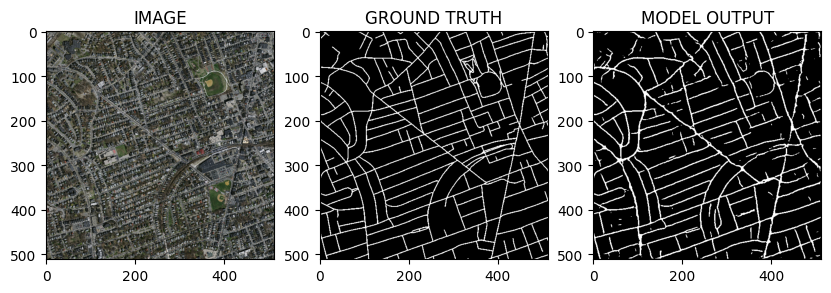

In [62]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))